In [1]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import os

In [3]:
from lsst.sims.photUtils import BandpassDict

In [4]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [5]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [6]:
import gedankenLSST

In [7]:
lsstchar = gedankenLSST.LSSTReq

In [8]:
import numpy as np

In [9]:
np.repeat(1, 5)

array([1, 1, 1, 1, 1])

In [10]:
import pandas as pd

In [11]:
lsstchar['meanNumVisits'] = pd.Series(np.repeat(3650.,6), index=['u','g','r','i','z','y'])

In [12]:
lsstchar['meanNumVisits']

u    3650
g    3650
r    3650
i    3650
z    3650
y    3650
dtype: float64

In [13]:
sn = gedankenLSST.GSN_Obs(mjd_center=49530., lsstrequirements=lsstchar)

In [14]:
df = sn.summary

In [15]:
df['filter'].unique()

array(['g', 'i', 'r', 'u', 'y', 'z'], dtype=object)

In [16]:
df.columns

Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc37050>]], dtype=object)

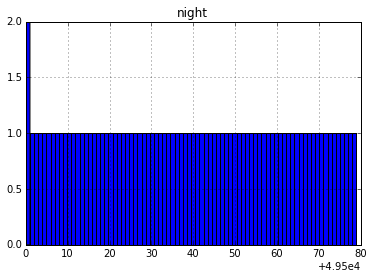

In [17]:
df[df['filter'] == 'u'].hist('night',bins=80)

In [18]:
s = gedankenLSST.SNObs(summarydf=df, t0=49530, lsst_bp=lsst_bp)

In [19]:
np.degrees(0)

0.0

In [20]:
s.radeg

0.0

In [21]:
l = s.lightcurve

480


/Users/rbiswas/.local/lib/python2.7/site-packages/gedankenLSST/sninLSST.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']


In [22]:
type(l)

pandas.core.frame.DataFrame

In [23]:
l.query('SNR > 5.').night

15     49514
16     49515
17     49516
18     49517
19     49518
20     49519
21     49520
22     49521
23     49522
24     49523
25     49524
26     49525
27     49526
28     49527
29     49528
30     49529
31     49530
32     49531
33     49532
34     49533
35     49534
36     49535
37     49536
38     49537
39     49538
40     49539
41     49540
42     49541
43     49542
44     49543
       ...  
426    49520
427    49521
428    49522
429    49523
430    49524
431    49525
432    49526
433    49527
434    49528
435    49529
436    49530
437    49531
438    49532
439    49533
440    49534
441    49535
442    49536
443    49537
444    49538
445    49539
446    49540
447    49541
448    49542
449    49543
450    49544
451    49545
452    49546
453    49547
454    49548
455    49549
Name: night, dtype: float64

In [24]:
import sncosmo

In [25]:
dir(sn)

['Observations',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_observations',
 'add_depth',
 'bumpFactors',
 'cadence',
 'dec',
 'fieldID',
 'meanNumObsperBand',
 'mjd_center',
 'ra',
 'requirements',
 'summary',
 'timeWindow',
 'uniformlySpacedEvents']